### Descrição - Modelo Time Dependent (ETS/ARIMA)

Separa todo o conjunto de dados fornecidos ``train.csv`` para divider em treinamento e teste. Utiliza modelos **ETS** e **ARIMA** para regressão temporal e forecasting


### Libraries

In [37]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from random import sample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(10, 6),
    titlesize=18,
    titleweight='bold'
    )
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    )
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    )


### Import dataset

In [3]:
cols = ["cfips", "microbusiness_density", "active"]
train_df = pd.read_csv('./files/train.csv',
                      usecols=["first_day_of_month"] + cols,
                      parse_dates=['first_day_of_month'],
                      index_col='first_day_of_month',
                      ).to_period('D').reindex(columns=cols)

train_df.index.names = ['Month']
# retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)
train_df = train_df.drop("active", axis=1)

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122265 entries, 2019-08-01 to 2022-10-01
Freq: D
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.8 MB
None


,cfips,microbusiness_density
Month,,
2019-08-01,1001,3.007682
2019-09-01,1001,2.884870
2019-10-01,1001,3.055843
2019-11-01,1001,2.993233
2019-12-01,1001,2.993233


In [4]:
# Treat values of population
# train["population"] = round(100 * train["active"] / train["microbusiness_density"])
# train["population"] = train["population"].astype(np.int64)
# display(train.loc[train['microbusiness_density'] == 0.0])
# display(train.loc[train['cfips'] == 28055])

### Trend model

#### Pivoted dataframe

In [5]:
# make pivot, setting date by index and cfips in columns
train_pivoted = train_df.pivot_table(index='Month', columns='cfips', values='microbusiness_density')
train_pivoted.head()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
2019-09-01,2.884870,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2019-10-01,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
2019-11-01,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.739270,1.362664,1.084903,...,1.200600,5.954897,3.845038,32.776520,6.234348,3.008812,26.920164,4.372520,2.683593,1.601994
2019-12-01,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.200600,5.911776,3.845038,32.806427,6.273890,3.088637,26.903938,4.310935,2.635385,1.584194


### ETS Model

In [6]:
# divide em treino e teste
X_train = train_pivoted.iloc[:-4, :]
X_test = train_pivoted.iloc[-4:, :]
X_train.index = X_train.index.to_timestamp()
# X_train.info()

In [7]:
# model = ExponentialSmoothing(X_train, trend='mul', damped_trend=True,
#                              seasonal='add', seasonal_periods=None,
#                             ).fit()#optimized=True,
#                                   #use_brute=True,
#                                   #remove_bias=True,
#                                   #method='bh')

# forecasts = model.forecast(4)

In [8]:
# forecasts

In [9]:
# plt.figure(figsize=(8,6))
# train_pivoted.iloc[:, 1500].plot(label='Original data', style='.-')
# forecasts.plot(label='Statsmodels forecast - ETS Model', style='.-')
# model.fittedvalues.plot(label='fitted values', style='.-')
# plt.title('cfips 1001 - Exponencial Smoothing' , fontsize=16)
# # plt.ylabel("Monthly Sales Amount");
# plt.xlabel("Month")
# plt.legend();

### ARIMA model

### Augmented Dickey Fuller Test

Requirements for Stationary Series:

- **Critical Value (5%)  >  Test Statistic**
- **p-value  <  0.05**


In [10]:
def adf_reqs(train_df):
    
    df = pd.DataFrame(index=train_df.columns,
                      columns=['test_statistic','p_value', 'critical_value_5pct'])
    
    for i in df.index:
        
        adftest = adfuller(train_df[i], autolag='AIC')
        df.loc[i,:] = [adftest[0], adftest[1], adftest[4]['5%']]        
    
    for col in df.columns: df[col] = df[col].astype(float)
    
    df_notstat = df.loc[(df.p_value > .05) & (df.test_statistic > df.critical_value_5pct)]
    df_notstat['stationary'] = 'not'
    df_notstat.drop(['test_statistic','p_value', 'critical_value_5pct'], axis=1, inplace=True)
    
    df = df.merge(df_notstat, how='left', on='cfips').fillna('yes')
    
    return df


In [11]:
adf_df = adf_reqs(train_pivoted)

In [12]:
# adf_df.loc[adf_df['stationary'] == 'yes']

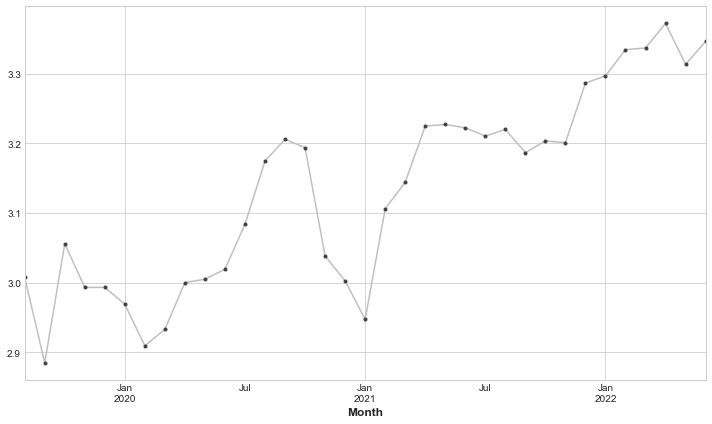

In [13]:
X_train[1001].plot(**plot_params);

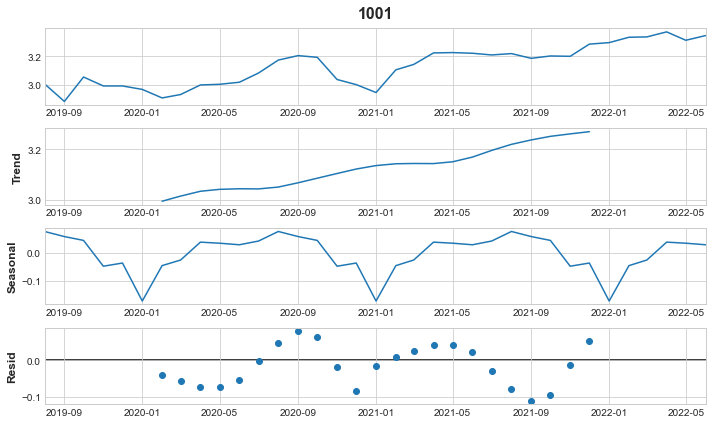

In [14]:
decomposition = sm.tsa.seasonal_decompose(X_train[1001], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# calculate SMAPE between forecasts and actual values
def smape_error(y_pred, y_true):
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)

In [ ]:
def best_pqd(df_train, df_pivoted, df_test):
    
    p, q, d = range(1,5), range(1,5), range(1,5)
    pqd_comb = list(itertools.product(p,q,d))   # return all possible combinations between the parameters
    df = pd.DataFrame(index=list(df_train.columns), columns=['p', 'q', 'd', 'testset_smaller_smape'])
    df.index.name = df_train.columns.name
    i = 0
    for cfip in list(df.index)[300:]:
        order=[]
        error = []
        
        for pqd in pqd_comb:
            try:
                model = ARIMA(df_train[cfip], order=pqd).fit()
                pred = model.predict(start=len(X_train[cfip]), end=(len(df_pivoted[cfip])-1))   # 2022-07 to 2022-10
                error.append(smape_error(pred.values, df_test[cfip].values))
            except:
                continue
        i+=1
        print(i)
        df.loc[cfip, :] = list(pqd_comb[error.index(min(error))]) + [min(error)]
    
    return df

df = best_pqd(X_train, train_pivoted, X_test)
df.to_csv('./files/ARIMA_best_pqd_p1-5_q1-5_d1-5_range_pt300_3135.csv', header=True, sep=",", index=True)

In [ ]:
# df.dropna()['testset_smaller_smape'].sort_values(ascending=False).head(20)

In [47]:
pqd_arima_df = pd.read_csv('./files/ARIMA_best_pqd_p1-5_q1-5_d1-5_range_pt300_600.csv', index_col=['cfips']).dropna()
# pqd_arima_df.index = X_train.columns[:300]
# pqd_arima_df.index.name = X_train.columns.name
pqd_arima_df

,p,q,d,testset_smaller_smape
cfips,,,,
8115,4.0,1.0,1.0,7.630006
8117,4.0,3.0,4.0,0.287217
8119,3.0,4.0,2.0,0.599437
8121,2.0,4.0,1.0,0.937040
8123,2.0,1.0,3.0,0.373656
...,...,...,...,...
17005,1.0,3.0,2.0,0.586115
17007,3.0,3.0,1.0,1.696866
17009,3.0,2.0,4.0,0.914337


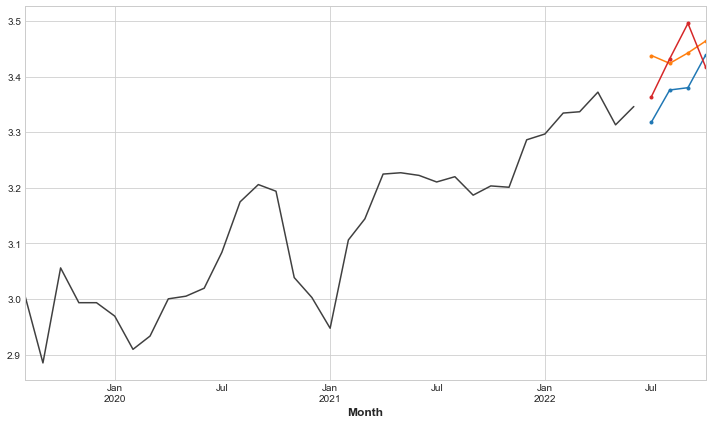

In [43]:
cfip = 1001
model = ARIMA(X_train[cfip], order=(3,2,2)).fit()
pred = model.predict(start=len(X_train[cfip]), end=(len(train_pivoted[cfip])-1))

model = SARIMAX(X_train[cfip], order=(3,2,2), seasonal_order=(3, 1, 2, 12)).fit()
pred_sarimax = model.predict(start=len(X_train[cfip]), end=(len(train_pivoted[cfip])-1))

# Plot ARIMA and SARIMAX
axs = X_train[cfip].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = X_test[cfip].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = pred.plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = pred_sarimax.plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
plt.show()

#### Trend features

In [ ]:
y = train_pivoted.copy()

# Create trend features
dp = DeterministicProcess(index=y.index,  # dates from the training data
                          order=2,        # quadratic trend
                          drop=True,      # drop terms to avoid collinearity
                          )

X = dp.in_sample()  # features for the training data
X.head()

#### Trend ML model

In [ ]:
# Test on 2022-10-01, last month training data. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(y.index, test_size=1, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression()
model.fit(X_train, y_train)        # use same features (X_train) to fit both targets ('BuildingMaterials' and 'FoodAndBeverage')

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

y_train_copy, y_test_copy = y_train.copy(), y_test.copy()

In [ ]:
# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")

### XGBoost model

#### Stacking dataframe

In [ ]:
X = pd.concat({'microbusinesses_density': train_pivoted}, names=[None, 'cfips'], axis=1).stack()
display(X.head())

y = X.pop("microbusinesses_density")
y.head()

In [ ]:
# reset index and separate by industries
X = X.reset_index('cfips')
X.head()

In [ ]:
# Label encoding for 'cfips' feature
for colname in X.select_dtypes(["int", "category"]):  #select_dtypes() returns dataframe with the columns matching the format
    X[colname], _ = X[colname].factorize()               #Encode the object as an enumerated type or categorical variable

X.head()

In [ ]:
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12
X.head()

In [ ]:
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

In [ ]:
y_fit.head()

In [ ]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

# Make predictions
y_fit_hybrid = pd.DataFrame(y_fit_boosted.unstack(),
                             index=y_fit_boosted.unstack().index,
                             columns=y_fit_boosted.unstack().columns,
                            )
y_pred_hybrid = pd.DataFrame(y_pred_boosted.unstack(),
                      index=y_pred_boosted.unstack().index,
                      columns=y_pred_boosted.unstack().columns,
                     )

# Sets negatives predicted values to 0
y_pred_hybrid[y_pred_hybrid < 0] = 0


In [ ]:
y_pred_hybrid.head(6)

In [ ]:
# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit_hybrid.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_hybrid.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")

### SMAPE

In [ ]:
# calculate SMAPE between forecasts and actual values
def smape(y_pred, y_true):
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)


In [ ]:
SMAPE = smape(y_pred_hybrid.values, y_test_copy.values)
error = 200 * np.abs(y_pred_hybrid.values - y_test_copy.values) / (np.abs(y_pred_hybrid.values) + np.abs(y_test_copy.values))
error_df = pd.DataFrame(error.T, index=list(y_pred_hybrid.columns)).squeeze().fillna(0)

print("\nSMAPE error (): ", SMAPE)
print("\ncfips higher error: ")
print(error_df.sort_values(ascending=False), "\n")

# Plot
error_df.plot(**plot_params);

In [ ]:
error_df[error_df <= 1.09].sort_values(ascending=False)

### Error analysis

In [ ]:
# Plot
cfips_ex = error_df.sort_values(ascending=False).index[:5]
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit_hybrid.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_hybrid.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")